# Complete Speech Accent Archive Analysis
Dastan Abdulla  
Ling 1340: Data Science for Linguists  
04/08/2024  

In [210]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [211]:
# Imports
import pandas as pd
import numpy as np
# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [212]:
bio_df = pd.read_pickle('../data/bio_df.pkl')
bio_df.head(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,phonetic_transcription,ethnologue_language_code,language_name,macroarea,coordinate
0,1,afrikaans,south africa,27.0,female,9.0,usa,0.50,academic,afrikaans1.wav,afrikaans1.txt,afr,Afrikaans,Africa,"(-30.559482, 22.937506)"
1,2,afrikaans,south africa,40.0,male,5.0,usa,10.00,academic,afrikaans2.wav,afrikaans2.txt,afr,Afrikaans,Africa,"(-30.559482, 22.937506)"
2,3,agni,côte d'ivoire,25.0,male,15.0,usa,1.20,academic,agni1.wav,agny1.txt,any,Anyin,Africa,"(7.539989, -5.54708)"
3,4,albanian,serbia,19.0,male,6.0,usa,3.00,naturalistic,albanian1.wav,albanian1.txt,als,Tosk Albanian,Eurasia,"(44.016521, 21.005859)"
4,5,albanian,albania,33.0,male,15.0,usa,0.04,naturalistic,albanian2.wav,albanian2.txt,aln,Gheg Albanian,Eurasia,"(41.153332, 20.168331)"


In [213]:
features_df = pd.read_pickle('../data/features_df.pkl')
features_df.head(5)

,speakerid,transcription,anterior,consonantal,labial,sagittal,back,constricted_glottis,continuant,coronal,...,long,nasal,round,sonorant,syllabic,velaric,voice,distributed,strident,tense
0,1,pʰlis kɔl stɛːlʌ ɑsk˺ ɜ tə bɹɪ̃ŋ ðiz θɪ̃ŋz̥ wɪ...,114,126,38,1,74,1,166,87,...,4,24,31,138,89,0,165,12,11,45
1,2,pʰliːz̥ kʰɔl stɛ̆lʌ ɔsk hɜ tŭ bɹiŋ ðiz θiŋz̥ ...,109,125,37,6,69,1,160,85,...,6,24,31,131,84,0,162,15,9,43
2,3,pliz kɑl stelə æs hɚ tu bɹɪ̃ŋ viz fɪŋ wɪf hɜɹ̆...,111,119,45,1,59,1,158,78,...,0,26,31,134,81,0,164,4,16,51
3,4,p̬liz kʰɔl stɛla æs xɜɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋks wɪ...,119,129,39,5,79,0,173,95,...,0,33,39,145,87,0,173,13,8,47
4,5,pliz kɔl stɛlə æsk hɛɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋs wɪð ...,122,136,37,1,63,0,171,97,...,4,35,33,138,87,0,159,15,11,41


In [214]:
saa_tran_df = pd.concat([bio_df, features_df], axis=1)

In [215]:
saa_tran_df.head(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,...,long,nasal,round,sonorant,syllabic,velaric,voice,distributed,strident,tense
0,1,afrikaans,south africa,27.0,female,9.0,usa,0.50,academic,afrikaans1.wav,...,4,24,31,138,89,0,165,12,11,45
1,2,afrikaans,south africa,40.0,male,5.0,usa,10.00,academic,afrikaans2.wav,...,6,24,31,131,84,0,162,15,9,43
2,3,agni,côte d'ivoire,25.0,male,15.0,usa,1.20,academic,agni1.wav,...,0,26,31,134,81,0,164,4,16,51
3,4,albanian,serbia,19.0,male,6.0,usa,3.00,naturalistic,albanian1.wav,...,0,33,39,145,87,0,173,13,8,47
4,5,albanian,albania,33.0,male,15.0,usa,0.04,naturalistic,albanian2.wav,...,4,35,33,138,87,0,159,15,11,41


# Preliminary setup
Before we begin building the classification models, we need to make sure that there ample instances of each tag or label for our model to learn from. i.e if there are only 2 instances for one native language, then our model will have an extra tag to differentiate from which would hurt the performance

In [216]:
feature_full_names = [
    'anterior',
    'consonantal',
    'labial',
    'sagittal',
    'back',
    'constricted_glottis',
    'continuant',
    'coronal',
    'delayed_release',
    'high',
    'lateral',
    'low',
    'long',
    'nasal',
    'round',
    'sonorant',
    'syllabic',
    'velaric',
    'voice',
    'distributed',
    'strident',
    'tense'
]


# Testing Correlation 
Before we build a prediction model, we need to check for correlation between the features and native_languages as it will give us an idea of how our model will perform.

In [217]:
from statsmodels.multivariate.manova import MANOVA
# Using MANOVA
str_maov = ''
for i in range(len(feature_full_names)):
    if i != len(feature_full_names) - 1:
        str_maov += feature_full_names[i] + ' + '
    else:
        str_maov += feature_full_names[i] + ' ~ language_name'
        
maov = MANOVA.from_formula(str_maov, data=saa_tran_df)
print(maov.mv_test())

                     Multivariate linear model
                                                                   
-------------------------------------------------------------------
           Intercept        Value   Num DF   Den DF  F Value Pr > F
-------------------------------------------------------------------
              Wilks' lambda 0.5361 22.0000 1029.0000 40.4666 0.0000
             Pillai's trace 0.4639 22.0000 1029.0000 40.4666 0.0000
     Hotelling-Lawley trace 0.8652 22.0000 1029.0000 40.4666 0.0000
        Roy's greatest root 0.8652 22.0000 1029.0000 40.4666 0.0000
-------------------------------------------------------------------
                                                                   
-------------------------------------------------------------------
     language_name       Value    Num DF    Den DF   F Value Pr > F
-------------------------------------------------------------------
          Wilks' lambda  0.0003 4796.0000 22721.7279  2.1173 0.0000
 


### 1. Wilks' Lambda
- **Intercept**: Wilks' lambda is 0.5361, indicating significant variance accounted for by the model.
- **language_name**: Extremely low Wilks' lambda (0.0003), strong evidence of significant differences in speech features across languages.

### 2. Pillai's Trace
- Indicates a substantial effect size (6.4575 for language_name), reinforcing the impact of language on speech features.

### 3. Hotelling-Lawley Trace
- A value of 10.5216 for `language_name` indicates a high degree of explained variance by the language variable among speech features.

### 4. Roy's Greatest Root
- The greatest root value (1.5318) along with its F Value (7.3777) and Pr > F (0.0000) highlights a significant maximum difference that can be attributed to language.

## Conclusion
The results clearly indicate that the language has a statistically significant effect on speech features, with very low p-values (< 0.0001) suggesting strong evidence against the null hypothesis. 


# Predicting Native Language

In [218]:
model_data = saa_tran_df[['language_name'] + feature_full_names]
model_data.head()

,language_name,anterior,consonantal,labial,sagittal,back,constricted_glottis,continuant,coronal,delayed_release,...,long,nasal,round,sonorant,syllabic,velaric,voice,distributed,strident,tense
0,Afrikaans,114,126,38,1,74,1,166,87,0,...,4,24,31,138,89,0,165,12,11,45
1,Afrikaans,109,125,37,6,69,1,160,85,0,...,6,24,31,131,84,0,162,15,9,43
2,Anyin,111,119,45,1,59,1,158,78,0,...,0,26,31,134,81,0,164,4,16,51
3,Tosk Albanian,119,129,39,5,79,0,173,95,0,...,0,33,39,145,87,0,173,13,8,47
4,Gheg Albanian,122,136,37,1,63,0,171,97,0,...,4,35,33,138,87,0,159,15,11,41


In [219]:
value_counts = model_data['language_name'].value_counts()
value_counts

language_name
English                       186
Spanish                        74
French                         44
Dutch                          42
Portuguese                     39
                             ... 
Baga Sitemu                     1
Guadeloupean Creole French      1
Zulu                            1
Central Bai                     1
Masbatenyo                      1
Name: count, Length: 219, dtype: int64

In [220]:
value_counts = model_data['language_name'].value_counts()
to_remove = value_counts[value_counts < 2].index
print(len(to_remove))
to_remove

95


Index(['Mankanya', 'Balanta-Ganja', 'Luba-Lulua', 'Mandinka',
       'Jamaican Creole English', 'Nyanja', 'Konkani (individual language)',
       'Lushai', 'Susu', 'Tetun Dili', 'Fataluku', 'Tajik', 'Moba', 'Turkmen',
       'Shilluk', 'Nandi', 'Klao', 'Nuer', 'Plateau Malagasy', 'Omani Arabic',
       'Southern Kurdish', 'Luxembourgish', 'Rundi', 'Yakut', 'Faroese',
       'Pedi', 'Sa'a', 'Kabyle', 'Adamawa Fulfulde', 'Papiamento', 'Kalanga',
       'Xaasongaxango', 'Arabic', 'Lingala', 'Khoekhoe', 'Gedeo',
       'Northern Pashto', 'Central Kanuri', 'Gan Chinese', 'Kinyarwanda',
       'Vengo', 'Ngemba', 'Jola-Fonyi', 'Carolinian', 'Chamorro', 'Anyin',
       'Zoroastrian Dari', 'Tatar', 'Ebira', 'Bini', 'Tofanma',
       'Fang (Cameroon)', 'Western Frisian', 'Sicilian', 'Kannada', 'Sarua',
       'Gallurese Sardinian', 'Huamalíes-Dos de Mayo Huánuco Quechua',
       'South Bolivian Quechua', 'Kirghiz', 'Western Panjabi', 'Lamaholot',
       'Pohnpeian', 'Mortlockese', 'Mossi', 'Mori

- Based on the value counts distribution, there is no benefit in keeping the labels that occur only once in our data, so it'd make sense to remove them.

In [221]:
model_data = model_data[~model_data['language_name'].isin(to_remove)]
value_counts = model_data['language_name'].value_counts()
value_counts

language_name
English                 186
Spanish                  74
French                   44
Dutch                    42
Portuguese               39
                       ... 
San Salvador Kongo        2
Mende (Sierra Leone)      2
North Azerbaijani         2
Belarusian                2
Malayalam                 2
Name: count, Length: 124, dtype: int64

In [222]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'combined_df' is your DataFrame with all features and the language label
X = model_data[feature_full_names]
y = model_data['language_name']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Initialize and train the RandomForestClassifier
model = LogisticRegression(max_iter=1500)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.23829787234042554


In [223]:
len(model_data['language_name'].unique())

124

The model did not perform very well when it comes to detecting the specific language that was spoken. But this is inherently a difficult task. Let's see if the true labels are at least in the top predictions.

In [224]:
def test_top_occurence(x_test, y_test, k):
    y_probs = model.predict_proba(x_test)
    top_preds_indices = np.argsort(y_probs, axis=1)[:, -k:]
    top_class_labels = np.array(model.classes_)[top_preds_indices]
    y_test_array = y_test.to_numpy()
    # Check if the true labels are within the top k predictions
    matches_top = np.array([y_test_array[i] in top_class_labels[i] for i in range(len(y_test_array))])
    return matches_top.mean()

top_k = list(range(1, 100, 1))
accuracies_feat = [test_top_occurence(X_test, y_test, k) for k in top_k]

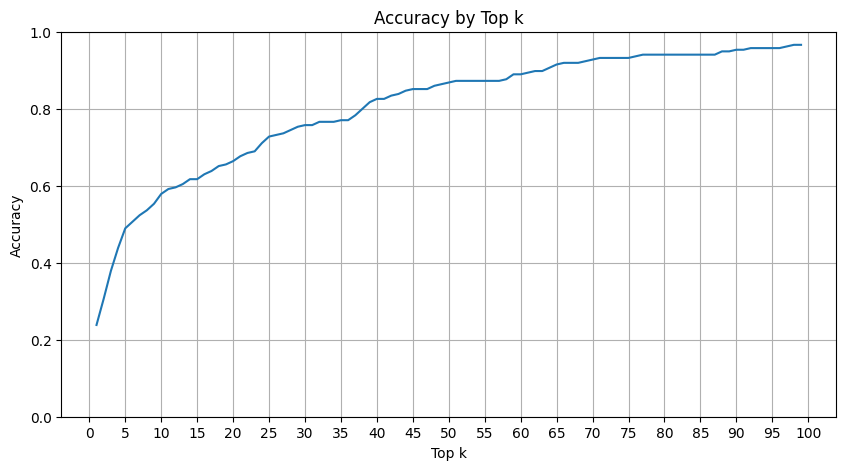

In [225]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  
plt.plot(top_k, accuracies_feat)  
plt.title('Accuracy by Top k')  
plt.xlabel('Top k')  
plt.ylabel('Accuracy') 
plt.grid(True) 
plt.xticks(range(0, 105, 5))  
plt.ylim(0, 1.0)  
plt.show()


# What if we used the Transcriptions?

In [226]:
saa_tran_df['transcription']

0       pʰlis kɔl stɛːlʌ ɑsk˺ ɜ tə bɹɪ̃ŋ ðiz θɪ̃ŋz̥ wɪ...
1       pʰliːz̥ kʰɔl stɛ̆lʌ ɔsk hɜ tŭ bɹiŋ ðiz θiŋz̥ ...
2       pliz kɑl stelə æs hɚ tu bɹɪ̃ŋ viz fɪŋ wɪf hɜɹ̆...
3       p̬liz kʰɔl stɛla æs xɜɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋks wɪ...
4       pliz kɔl stɛlə æsk hɛɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋs wɪð ...
                              ...                        
2675    pʰliz̥ kʰɔl stɛ̝lə æsk hɛr tuː brɪ̃ŋ diz tɪ̃ŋz...
2676    pʰəl̥ɪːz̥ kʰɔl ɛstɛlə æsk hɛɹ tʰu brɪ̃ːŋ dɪːs ...
2678    plĭs kɔl əstɛlə æs xɛɹ tu βɹĩːŋ dis θiŋs wɪt...
2688    pliːs kʰʷɔl st̪ɛːla as hə˞ t̪ʰʷu bɹɪ̃ŋ d̪ɪs t̪...
2941    pliːz̥ kɔl ĕstɛlʌ xæs xeɹ tʰu bɾɪ̃ŋ d̪iːs θɪ̃...
Name: transcription, Length: 1269, dtype: object

In [227]:
model_data = saa_tran_df[['transcription', 'language_name']]
model_data

,transcription,language_name
0,pʰlis kɔl stɛːlʌ ɑsk˺ ɜ tə bɹɪ̃ŋ ðiz θɪ̃ŋz̥ wɪ...,Afrikaans
1,pʰliːz̥ kʰɔl stɛ̆lʌ ɔsk hɜ tŭ bɹiŋ ðiz θiŋz̥ ...,Afrikaans
2,pliz kɑl stelə æs hɚ tu bɹɪ̃ŋ viz fɪŋ wɪf hɜɹ̆...,Anyin
3,p̬liz kʰɔl stɛla æs xɜɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋks wɪ...,Tosk Albanian
4,pliz kɔl stɛlə æsk hɛɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋs wɪð ...,Gheg Albanian
...,...,...
2675,pʰliz̥ kʰɔl stɛ̝lə æsk hɛr tuː brɪ̃ŋ diz tɪ̃ŋz...,Dari
2676,pʰəl̥ɪːz̥ kʰɔl ɛstɛlə æsk hɛɹ tʰu brɪ̃ːŋ dɪːs ...,Iranian Persian
2678,plĭs kɔl əstɛlə æs xɛɹ tu βɹĩːŋ dis θiŋs wɪt...,Spanish
2688,pliːs kʰʷɔl st̪ɛːla as hə˞ t̪ʰʷu bɹɪ̃ŋ d̪ɪs t̪...,Masbatenyo


In [228]:
value_counts = model_data['language_name'].value_counts()
to_remove = value_counts[value_counts < 2].index
model_data = model_data[~model_data['language_name'].isin(to_remove)]
value_counts = model_data['language_name'].value_counts()
value_counts

language_name
English                 186
Spanish                  74
French                   44
Dutch                    42
Portuguese               39
                       ... 
San Salvador Kongo        2
Mende (Sierra Leone)      2
North Azerbaijani         2
Belarusian                2
Malayalam                 2
Name: count, Length: 124, dtype: int64

In [229]:
def phoneme_tokenizer(transcript):
    no_whitespace_transcript = transcript.replace(' ', '')
    return [*no_whitespace_transcript]

In [230]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Extracting the phoneme transcriptions and language labels
transcriptions = model_data['transcription']
languages = model_data['language_name']

vectorizer = TfidfVectorizer(max_features=1500 , tokenizer=phoneme_tokenizer, lowercase=False, token_pattern=None)
X = vectorizer.fit_transform(transcriptions)
y = model_data['language_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

model = LogisticRegression(max_iter=1500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.2170212765957447


In [231]:
top_k = list(range(1, 100, 1))
accuracies_vec = [test_top_occurence(X_test, y_test, k) for k in top_k]

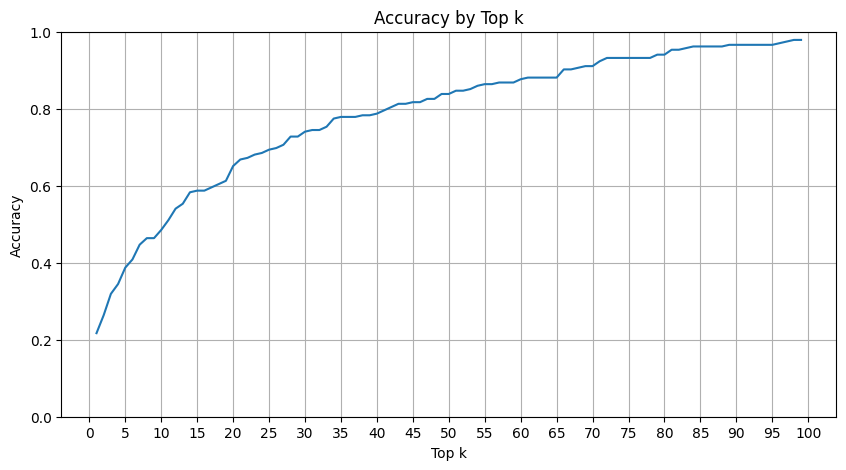

In [232]:
import matplotlib.pyplot as plt

# Plotting the data
plt.figure(figsize=(10, 5))  
plt.plot(top_k, accuracies_vec)  
plt.title('Accuracy by Top k')  
plt.xlabel('Top k')  
plt.ylabel('Accuracy') 
plt.grid(True) 
plt.xticks(range(0, 105, 5))  # Ensure all model numbers are labeled
plt.ylim(0, 1.0)  # Optionally set the y-axis limits to zoom in on accuracies
plt.show()

# Transcription vs Features Model

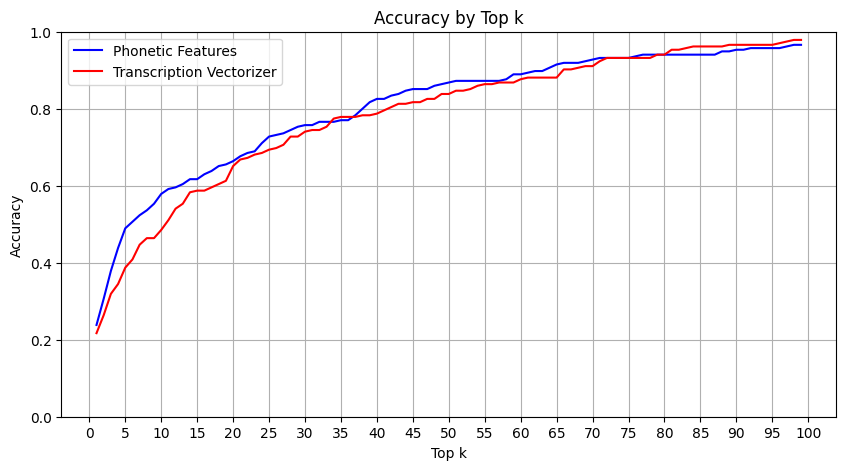

In [233]:
# Plotting the data
plt.figure(figsize=(10, 5))  
plt.plot(top_k, accuracies_feat, color = 'blue', label = 'Phonetic Features')  
plt.plot(top_k, accuracies_vec, color = 'red', label = 'Transcription Vectorizer')  
plt.title('Accuracy by Top k')  
plt.xlabel('Top k')  
plt.ylabel('Accuracy') 
plt.grid(True) 
plt.xticks(range(0, 105, 5))  # Ensure all model numbers are labeled
plt.ylim(0, 1.0)  # Optionally set the y-axis limits to zoom in on accuracies
plt.legend()
plt.show()

# Predicting Country

In [197]:
len(saa_tran_df['country'].unique())

159

In [198]:
model_data = saa_tran_df[['country'] + feature_full_names]
model_data.head()

,country,anterior,consonantal,labial,sagittal,back,constricted_glottis,continuant,coronal,delayed_release,...,long,nasal,round,sonorant,syllabic,velaric,voice,distributed,strident,tense
0,south africa,114,126,38,1,74,1,166,87,0,...,4,24,31,138,89,0,165,12,11,45
1,south africa,109,125,37,6,69,1,160,85,0,...,6,24,31,131,84,0,162,15,9,43
2,côte d'ivoire,111,119,45,1,59,1,158,78,0,...,0,26,31,134,81,0,164,4,16,51
3,serbia,119,129,39,5,79,0,173,95,0,...,0,33,39,145,87,0,173,13,8,47
4,albania,122,136,37,1,63,0,171,97,0,...,4,35,33,138,87,0,159,15,11,41


In [199]:
value_counts = model_data['country'].value_counts()
to_remove = value_counts[value_counts < 2].index
to_remove

Index(['malawi', 'rwanda', 'niger', 'namibia', 'equatorial guinea',
       'faroe islands', 'luxembourg', 'burundi', 'montenegro', 'madagascar',
       'andorra', 'turkmenistan', 'oman', 'curaçao', 'togo', 'benin',
       'new zealand', 'zambia', 'virgin islands, u.s.', 'gabon', 'nicaragua',
       'cuba', 'yemen', 'chad', 'burkina faso', 'trinidad and tobago',
       'liechtenstein', 'mauritius', 'lesotho', 'martinique', 'kyrgyzstan',
       'panama', 'tajikistan'],
      dtype='object', name='country')

In [200]:
model_data = model_data[~model_data['country'].isin(to_remove)]
value_counts = model_data['country'].value_counts()
value_counts

country
usa                         129
china                        52
india                        42
brazil                       33
belgium                      31
                           ... 
solomon islands               2
azerbaijan                    2
costa rica                    2
northern mariana islands      2
slovakia                      2
Name: count, Length: 126, dtype: int64

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming 'combined_df' is your DataFrame with all features and the language label
X = model_data[feature_full_names]
y = model_data['country']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Initialize and train the RandomForestClassifier
model = LogisticRegression(max_iter=1500)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.23387096774193547


That accuracy is not great let's see if we can improve it using a regression model using the longitude and latitudes for each country

In [202]:
model_data = saa_tran_df[['country', 'coordinate'] + feature_full_names]
model_data.head()

,country,coordinate,anterior,consonantal,labial,sagittal,back,constricted_glottis,continuant,coronal,...,long,nasal,round,sonorant,syllabic,velaric,voice,distributed,strident,tense
0,south africa,"(-30.559482, 22.937506)",114,126,38,1,74,1,166,87,...,4,24,31,138,89,0,165,12,11,45
1,south africa,"(-30.559482, 22.937506)",109,125,37,6,69,1,160,85,...,6,24,31,131,84,0,162,15,9,43
2,côte d'ivoire,"(7.539989, -5.54708)",111,119,45,1,59,1,158,78,...,0,26,31,134,81,0,164,4,16,51
3,serbia,"(44.016521, 21.005859)",119,129,39,5,79,0,173,95,...,0,33,39,145,87,0,173,13,8,47
4,albania,"(41.153332, 20.168331)",122,136,37,1,63,0,171,97,...,4,35,33,138,87,0,159,15,11,41


In [203]:
import math


def convert_to_radians(coord):
    lat, long = coord
    return (math.radians(lat), math.radians(long))

model_data['coordinate_rad'] = model_data['coordinate'].apply(convert_to_radians)

C:\Users\atomicPC\AppData\Local\Temp\ipykernel_20388\4251402541.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['coordinate_rad'] = model_data['coordinate'].apply(convert_to_radians)


In [204]:
model_data = model_data[~model_data['country'].isin(to_remove)]
value_counts = model_data['country'].value_counts()
value_counts

country
usa                         129
china                        52
india                        42
brazil                       33
belgium                      31
                           ... 
solomon islands               2
azerbaijan                    2
costa rica                    2
northern mariana islands      2
slovakia                      2
Name: count, Length: 126, dtype: int64

In [205]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import mean_squared_error

# Example DataFrame creation (replace this with your actual DataFrame)
# df = pd.DataFrame(data)

# Splitting the 'coordinate' into 'latitude' and 'longitude'

X = model_data[feature_full_names]
y = pd.DataFrame(model_data['coordinate'].tolist(), columns=['latitude', 'longitude'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


# Example with Random Forest
model = MultiOutputRegressor(RandomForestRegressor(random_state=1))
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Clipping latitude to be between -90 and 90
y_pred[:, 0] = np.clip(y_pred[:, 0], -90, 90)

# Clipping longitude to be between -180 and 180
y_pred[:, 1] = np.clip(y_pred[:, 1], -180, 180)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1714.7401417343617


In [206]:
import math


country_info = model_data.drop_duplicates(subset=['country', 'coordinate'])
country_info = country_info[['country', 'coordinate']]

country_info['coordinate_rad'] = country_info['coordinate'].apply(convert_to_radians)
country_info.head()

,country,coordinate,coordinate_rad
0,south africa,"(-30.559482, 22.937506)","(-0.5333635786039418, 0.40033500189595445)"
2,côte d'ivoire,"(7.539989, -5.54708)","(0.13159763361415475, -0.09681480987152706)"
3,serbia,"(44.016521, 21.005859)","(0.768233216723227, 0.36662140175968355)"
4,albania,"(41.153332, 20.168331)","(0.718261141566343, 0.35200378058204046)"
5,ethiopia,"(9.145, 40.489673)","(0.15961036009488144, 0.7066781069058501)"


In [207]:
# Initialize NearestNeighbors with 30 neighbors
from sklearn.neighbors import NearestNeighbors

nn_model = NearestNeighbors(n_neighbors=10, algorithm='ball_tree', metric='haversine')
nn_model.fit(country_info['coordinate'].tolist())
distances, indices = nn_model.kneighbors(y_pred)
indices.shape

(248, 10)

In [208]:
y_test['coordinate'] = list(zip(y_test['latitude'], y_test['longitude']))
coordinate_to_country = dict(zip(model_data['coordinate'], model_data['country']))

# Use the map to create the 'country' column in y_test
y_test['country'] = y_test['coordinate'].map(coordinate_to_country)
y_test.head()

,latitude,longitude,coordinate,coordinate_rad,country
373,30.375321,69.345116,"(30.375321, 69.345116)","(0.5301493628001765, 1.2103005943774001)",pakistan
944,39.074208,21.824312,"(39.074208, 21.824312)","(0.6819735822091084, 0.3809061013825087)",greece
256,20.593684,78.962880,"(20.593684, 78.96288)","(0.35942759091527593, 1.37816224285718)",india
51,56.263920,9.501785,"(56.26392, 9.501785)","(0.9819906540786879, 0.1658374330666094)",denmark
139,37.090240,-95.712891,"(37.09024, -95.712891)","(0.6473468083549017, -1.6705050845524478)",usa


In [209]:
country_info.iloc[indices[0]]['country'].tolist()

['el salvador',
 'ecuador',
 'mexico',
 'costa rica',
 'peru',
 'honduras',
 'chile',
 'colombia',
 'jamaica',
 'bolivia']

In [172]:
correct = 0
total = 0
for index, pred_entry in enumerate(indices):
    curr_list = country_info.iloc[pred_entry]['country'].tolist()
    if y_test.iloc[index].country in curr_list:
        correct+=1
    total+=1

print('accuracy: ', correct/total)

accuracy:  0.08064516129032258


# Predicting Continent/Region

In [ ]:
model_data = saa_tran_df[['macroarea'] + feature_full_names]
model_data.head()

,macroarea,anterior,consonantal,labial,sagittal,back,constricted_glottis,continuant,coronal,delayed_release,...,long,nasal,round,sonorant,syllabic,velaric,voice,distributed,strident,tense
0,Africa,114,126,38,1,74,1,166,87,0,...,4,24,31,138,89,0,165,12,11,45
1,Africa,109,125,37,6,69,1,160,85,0,...,6,24,31,131,84,0,162,15,9,43
2,Africa,111,119,45,1,59,1,158,78,0,...,0,26,31,134,81,0,164,4,16,51
3,Eurasia,119,129,39,5,79,0,173,95,0,...,0,33,39,145,87,0,173,13,8,47
4,Eurasia,122,136,37,1,63,0,171,97,0,...,4,35,33,138,87,0,159,15,11,41


In [ ]:
model_data['macroarea'].value_counts()

macroarea
Eurasia           1047
Africa             173
Papunesia           38
North America        7
South America        3
Eurasia-Africa       1
Name: count, dtype: int64

In [ ]:
model_data = model_data[model_data['macroarea'] != 'Eurasia-Africa']
model_data['macroarea'].value_counts()

macroarea
Eurasia          1047
Africa            173
Papunesia          38
North America       7
South America       3
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming 'combined_df' is your DataFrame with all features and the language label
X = model_data[feature_full_names]
y = model_data['macroarea']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Initialize and train the RandomForestClassifier
model = LogisticRegression(max_iter=1500)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8267716535433071


- It seems like we can at least predict the continent really well at least.

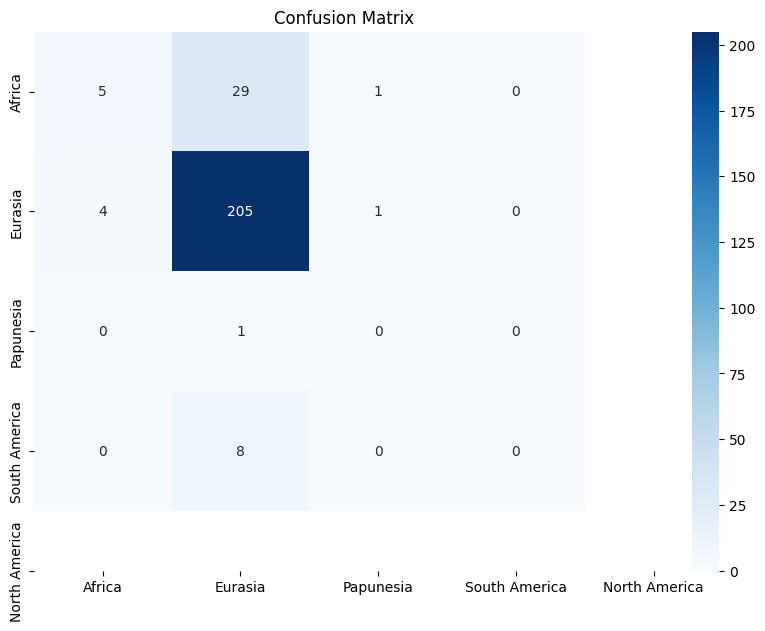

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

class_labels = list(model_data['macroarea'].unique())
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.show()
